In [21]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import os


In [22]:
#Define parameters used in script:
#Reaction parameters
v_plasma = 14.5 #in ml (volume used in plasma extraction)
v_elution = 150. #in ul (volume of purified DNA obtained from v_plasma)
v_ddpcr = 20 #in ul (standard volume of ddPCR)
droplet_size = 0.85e-3 #in (approx value from BioRad ddPCR)
v_input_quant = 1 #in ul (input DNA from quantification, for 20ul total reaction)
v_input_preamp = 8.5 #in ul (input DNA for preamp)

#Analysis and plot parameters
#Threshold values of MAF to pick SNPs used for fetral fraction quantification 
min_thres=.75 # Minimum MAF threshold to pick SNP for fetal fraction determination (MAF = fetal_frac / 2)
max_thres=20. # Max MAF threshold to pick SNP for fetal fraction determination
SNP_min_droplets = 100 #Min number of positive droplets (FAM+VIC) to use assay in fetal fraction calculation
resolfrac=0.5 #Resolution of histogram (in % MAF)
maxfrac=50 #Maximum value of histogram (in % MAF)

In [23]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams["font.family"] = 'Sans-serif'
matplotlib.rcParams["font.size"] = 8

input_folder = './../NIPT_FF/'
csv_folder = 'csv_files/'
input_file = input_folder + csv_folder + '20170524_NIPT017FF.csv'
Sample_name = 'NIPT017'

SNP_assays = ('SNP1-FAM','SNP2-FAM','SNP3-FAM','SNP4-FAM','SNP5-FAM',
             'SNP7-FAM','SNP9-FAM','SNP10-FAM','SNP12-FAM','SNP13-FAM',
             'SNP14-FAM','SNP16-FAM','SNP17-FAM','SNP18-FAM','SNP19-FAM',
            'SNP20-FAM','SNP22-FAM','SNP23-FAM','SNP24-FAM','SNP25-FAM',
            'SNP26-FAM','SNP27-FAM','SNP28-FAM','SNP30-FAM','SNP31-FAM',
            'SNP32-FAM','SNP33-FAM','SNP34-FAM','SNP35-FAM','SNP36-FAM',
            'SNP37-FAM','SNP38-FAM','SNP39-FAM','SNP42-FAM',
            'SNP44-FAM','SNP46-FAM','SNP47-FAM','SNP48-FAM','SNP49-FAM',
            'SNP50-FAM','SNP51-FAM','SNP52-FAM','SNP55-FAM','SNP56-FAM',
            'SNP57-FAM','SNP58-FAM','SNP59-FAM','Y1-FAM')
Quant_assays = ('EIF2C1-FAM','RPP30-FAM','TERT-VIC')
#'RNaseP-VIC', remove this quant assay as it underestimates
list_na =['No Call']

cols_snp=['Sample','Target','Conc(copies/µL)','Positives','Negatives',
          'Ch1+Ch2+', 'Ch1+Ch2-', 'Ch1-Ch2+', 'Ch1-Ch2-']

cols_quant=['Sample','Target','Conc(copies/µL)','Positives','Negatives',
            'PoissonConfidenceMax68', 'PoissonConfidenceMin68']

log_columns = ['Parameter', Sample_name]


output_folder = input_folder + Sample_name + '/output_files/'
figure_folder = input_folder + Sample_name + '/Figures/'
log_folder = input_folder + Sample_name + '/log_files/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

if not os.path.exists(log_folder):
    os.makedirs(log_folder)

In [26]:
def CreateMAFDataframe(df, Sample_name, SNP_assays, SNP_min_droplets, cols_snp):
    '''
    Calculate Minor Allele Fraction of SNP assay panel.
    First filter df for columns of interest and removing SNP assays with low droplet counts
    df: Dataframe from Biorad ddPCR experiment
    SNP_assay: list with SNP assay names (Target column)
    SNP_min_droplets: Minimum total number of droplets (FAM+VIC) to consider assat useful
    cols_snp: columns required for snp analyisis.
    '''    
    try:
        rows_filter = ((df.Target.isin(SNP_assays)) &
                       (df.Sample == Sample_name) &
                       (df['Ch1+Ch2+']+df['Ch1+Ch2-']+df['Ch1-Ch2+'] > SNP_min_droplets))
        
        new_df = df.loc[rows_filter, cols_snp]
        
        N_total = new_df['Ch1+Ch2+'] + new_df['Ch1-Ch2+'] + new_df['Ch1+Ch2-'] + new_df['Ch1-Ch2-']
        N_allele1 = new_df['Ch1+Ch2+'] + new_df['Ch1+Ch2-']
        N_allele2 = new_df['Ch1+Ch2+'] + new_df['Ch1-Ch2+']

        new_df['Allele 1'] = - np.log(1.0 - N_allele1 / N_total) * N_total
        new_df['Allele 2'] = - np.log(1.0 - N_allele2 / N_total) * N_total
        new_df['MAF'] =  np.abs( new_df[['Allele 1','Allele 2']].min(axis=1) / 
                                (new_df['Allele 1'] + new_df['Allele 2']) * 100. )

    except IOError as e:
        errno, strerror = e.args
        print("I/O error({0}): {1}".format(errno, strerror))    
    
    except ZeroDivisionError as err:
        print('Handling run-time error:', err)
    
    except ValueError:
        print("No valid integer in line.")
         
    return new_df


def CreateQuantDataframe(df, Sample_name, Quant_assays, cols_quant):
    '''
    Create Dataframe with cfDNA quantification panel.
    '''    
    rows_filter = ((df.Target.isin(Quant_assays)) 
                   & (df.Sample == Sample_name)
                   & (df.Positives != 0))

    new_df = df.loc[rows_filter, cols_quant]       
    new_df['SD_Max_Qsoft'] = new_df['PoissonConfidenceMax68'] - new_df['Conc(copies/µL)']
    new_df['SD_Min_Qsoft'] = new_df['Conc(copies/µL)'] - new_df['PoissonConfidenceMin68']

    N_total = new_df['Positives'] + new_df['Negatives']
    N_positive = new_df['Positives']

    new_df['total_DNA_input'] = - (np.log(1.0- N_positive / N_total) * N_total 
                                /  (droplet_size * N_total) * v_ddpcr)

    #Error propagation of counts
    new_df['SD_total_DNA_input'] = (np.sqrt(N_positive) / (N_total-N_positive) * N_total / 
                                    (droplet_size * N_total) * v_ddpcr)
    #Compare errors quantasoft
    new_df['errors_quantasoft'] = v_ddpcr * ((new_df['SD_Max_Qsoft'] + new_df['SD_Min_Qsoft']) / 2.)
    
    return new_df

def print_results(df_quant, df_snp):

    print("Parameters used:\n\
    --------------------------------------------------\n\
    volume plasma extracted: %.1f ml volume elution DNA: %.1f ul\n\
    volume input DNA quantification: %.1f ul\n\n\
    volume ddpcr reaction: %.1f ul, droplet_size: %.1f nl\n\n"
            % (v_plasma,v_elution,v_input_quant,v_ddpcr, droplet_size*1000,))

    print("DNA input for quantification (in genomic copies):\n\
    --------------------------------------------------\n\
    Mean: %.1f, Median: %.1f. SD:%.1f\nAverage Poisson noise: %.1f \
    Quantasoft Poisson noise: %.1f\n\n"
            % (df_quant.total_DNA_input.mean(), df_quant.total_DNA_input.median(), 
              df_quant.total_DNA_input.std(), df_quant.SD_total_DNA_input.mean(), df_quant.errors_quantasoft.mean()))


    #Output of plasma in 1ml basis
    print("Concentration cfDNA per ml plasma (in genomic copies):\n\
    ------------------------------------------------------\n\
    Total: %.1f+-%.1f (%.1f) [mean+-SD (Poisson SD)]" % (C_cfDNA, SD_cfDNA, PoissSD_cfDNA))
    
    print("Number of SNPs in range MAF: %i-%i%%: %i\n\
    \tMean = %4.2f\n\tMedian = %4.2f\n\tSD = %4.2f\n\
    \tY chromosome fraction: %.1f%%\n\n\
    Expected SD from quantitation error: %4.2f\n\
    Expected SD from fetal allele noise: %4.2f"
    %( min_thres, max_thres, len(ffrac), ffrac.mean(), ffrac.median(),
      ffrac.std(), Y_fraction, Err_fetfrac_1, Err_fetfrac_2))

def Make_SNP_plot():
  
    matplotlib.rcParams['xtick.labelsize'] = 16 
    matplotlib.rcParams['ytick.labelsize'] = 16 
    matplotlib.rcParams['axes.labelsize'] = 16 
    hist, bin_edges = np.histogram(df_snp['MAF'],bins=int(maxfrac/resolfrac),range=(0,maxfrac))
    cumhist = np.cumsum(hist)

    #Historam figure
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    fig.suptitle(Sample_name, fontsize = 18 )
    x = np.arange(min(bin_edges), max(bin_edges), 0.1);
    y = len(ffrac)/(math.sqrt(2*3.14*(ffrac.std()/2)**2)) * np.exp(-(x-ffrac.median()/2)**2/(2*(ffrac.std()/2)**2))
    ax[0].plot(x, y)
    ax[0].bar(bin_edges[:-1],hist,width=resolfrac,color='#7694C5')
    ax[0].set_ylim(0,max(hist)+1)
    ax[0].set_xlim(min(bin_edges), max(bin_edges))
    ax[0].axvline(x=min_thres, ymin=min(bin_edges), ymax=max(bin_edges), linewidth=0.5, color ='k')
    ax[0].axvline(x=max_thres, ymin=min(bin_edges), ymax=max(bin_edges), linewidth=0.5, color ='k')
    ax[0].set_xlabel('Minor Allele fraction observed (%)')

    ax[0].set_ylabel('# of SNP tests')
    #Plot text squares
    ax[0].text(0.95,0.95, 'N= %i, Fetal fraction: %3.1f$\pm$%3.1f%% ' % (ffrac.len(), ffrac.median(),ffrac.std()),
            style='italic', transform=ax[0].transAxes, horizontalalignment='right', verticalalignment='top',
                fontsize=18, bbox={'facecolor':'white', 'alpha':0.8, 'pad':8})
    ax[0].text(0.95,0.8, 'Y chromosome: %.1f%% ' % (Y_fraction),
            style='italic', transform=ax[0].transAxes, horizontalalignment='right', verticalalignment='top',
                fontsize=18, bbox={'facecolor':'white', 'alpha':0.8, 'pad':8})

    #Cumulative sum subplot
    ax[1].plot(bin_edges[:-1], cumhist)
    plt.xlim(min(bin_edges), max(bin_edges))
    ax[1].set_ylim(0,max(cumhist)+1)
    ax[1].set_xlim(min(bin_edges), max(bin_edges))
    ax[1].set_xlabel('Minor Allele fraction observed (%)')
    ax[1].set_ylabel('Cumulative of SNP tests')
    ax[1].text(0.05,0.95, "[cfDNA] = %.1f$\pm$%.1f (%.1f) genomic copies / ml plasma"
               % (C_cfDNA, SD_cfDNA, PoissSD_cfDNA), style='italic', transform=ax[1].transAxes, 
                   horizontalalignment='left', verticalalignment='top',
                fontsize=16, bbox={'facecolor':'white', 'alpha':0.8, 'pad':8})
    ax[1].text(0.05,0.8, "Expected SD in fetal fraction: %.1f%% (%.1f%%)"
               % (Err_fetfrac_1, Err_fetfrac_2), style='italic', transform=ax[1].transAxes, 
               horizontalalignment='left', verticalalignment='top',
                fontsize=16, bbox={'facecolor':'white', 'alpha':0.8, 'pad':8})


    #Plot inset
    left, bottom, width, height = [0.26, 0.4, 0.2, 0.25]
    axinset = fig.add_axes([left, bottom, width, height])
    axinset.plot(x, y)
    axinset.bar(bin_edges[:-1],hist,width=resolfrac,color='#7694C5')
    axinset.set_ylim(0,10)
    axinset.set_xlim(min(bin_edges), ffrac.mean())
    axinset.tick_params(axis='both', labelsize=14) 
    fig.tight_layout()
    fig.savefig( figure_folder + Sample_name + '_fig.pdf')
    
def QuantifyDNAInput(df_quant):
    C_cfDNA =  df_quant.total_DNA_input.mean() * v_elution / v_input_quant / v_plasma
    SD_cfDNA =  df_quant.total_DNA_input.std() * v_elution / v_input_quant / v_plasma
    PoissSD_cfDNA =  df_quant.SD_total_DNA_input.mean() * v_elution / v_input_quant / v_plasma
    DNA_input_preamp = C_cfDNA * v_plasma * (v_input_preamp / v_elution)
    Err_input_preamp = SD_cfDNA * v_plasma * (v_input_preamp / v_elution)
    return C_cfDNA, SD_cfDNA, PoissSD_cfDNA, DNA_input_preamp, Err_input_preamp
    

def QuantifySNPresults(df_snp):
    #Determine fetal fraction with all alleles between 1-20%
    ffrac = 2 * df_snp['MAF'][(df_snp['MAF']>min_thres) & (df_snp['MAF']<max_thres)]

    #Expected SD in fetal fraction due to fluctuations of input preAmp DNA (assuming perfect amplification)
    #First determine expected counts coming from baby
    InputDNA_Fetal_Allele = DNA_input_preamp * ( ffrac.median() / 2 ) / 100
    Err_InputDNA_Fetal_Allele  = Err_input_preamp * ( ffrac.median() / 2 ) / 100 
    ErrPoiss_InputDNA_Fetal_Allele  = math.sqrt( InputDNA_Fetal_Allele )

    #Calculate Errors in Fetal Fraction
    Err_fetfrac_1 = ( Err_InputDNA_Fetal_Allele / DNA_input_preamp ) * 100 * 2
    Err_fetfrac_2 = ( ErrPoiss_InputDNA_Fetal_Allele / DNA_input_preamp ) * 100 * 2

    #Calculate fraction of Y Chromosome
    Y_fraction = abs(df_snp[df_snp.Target == 'Y1-FAM']['MAF'].values[0])
    return ffrac, InputDNA_Fetal_Allele, Err_InputDNA_Fetal_Allele, \
    ErrPoiss_InputDNA_Fetal_Allele, Err_fetfrac_1, Err_fetfrac_2, Y_fraction
    
def WriteListToCSV(csv_file,csv_columns,data_list):
    try:
        with open(csv_file, 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(csv_columns)
            for data in data_list:
                writer.writerow(data)
    except IOError as e:
        errno, strerror = e.args
        print("I/O error({0}): {1}".format(errno, strerror))    
    
    except ValueError:
        print("No valid integer in line.")
        
    return

def MakeOutputTable(df_quant, df_snp):
    #Prepare SNP results for output (output minor allele fraction of each SNP)
    df1 = df_snp[['Target','MAF']].copy()
    df1['Target'] = df1.Target.map(lambda x: x.rstrip('-FAMVIC'))
    df1['#'] = [int(snp[3:]) if snp[:3] == 'SNP' else int(1e10) for snp in df1['Target'].values]
    df1.sort_values(by='#',inplace=True)
    df1.drop('#', inplace=True, axis=1)
    df1 = df1.set_index('Target')
    df1.columns = [ Sample_name ]

    #Prepare quantification results for output (output total DNA input used in quantification)
    df2 = df_quant[['Target','total_DNA_input']].copy()#output_table
    df2 = df2.set_index('Target')
    df2 = df2.rename({'EIF2C1-FAM': 'Q1', 'RNaseP-VIC': 'Q2', 'RPP30-FAM' : 'Q3', 'TERT-VIC' : 'Q4'})
    df2.sort_index(inplace=True)
    df2.columns = [ Sample_name ]

    #Merge output information and save in folder
    df_merge = pd.concat((df1,df2))
    return df_merge







def Make_SNP_plot2():
  
    matplotlib.rcParams['xtick.labelsize'] = 16 
    matplotlib.rcParams['ytick.labelsize'] = 16 
    matplotlib.rcParams['axes.labelsize'] = 16 
    hist, bin_edges = np.histogram(df_snp['MAF'],bins=int(maxfrac/resolfrac),range=(0,maxfrac))
    cumhist = np.cumsum(hist)

    #Historam figure
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    fig.suptitle(Sample_name, fontsize = 18 )
    x = np.arange(min(bin_edges), max(bin_edges), 0.1);
    y = len(ffrac)/(math.sqrt(2*3.14*(ffrac.std()/2)**2)) * np.exp(-(x-ffrac.median()/2)**2/(2*(ffrac.std()/2)**2))
    ax.plot(x, y)
    ax.bar(bin_edges[:-1],hist,width=resolfrac,color='#7694C5')
    ax.set_ylim(0,max(hist)+1)
    ax.set_xlim(min(bin_edges), max(bin_edges))
    ax.axvline(x=min_thres, ymin=min(bin_edges), ymax=max(bin_edges), linewidth=0.5, color ='k')
    ax.axvline(x=max_thres, ymin=min(bin_edges), ymax=max(bin_edges), linewidth=0.5, color ='k')
    ax.set_xlabel('Minor Allele fraction observed (%)')

    ax.set_ylabel('# of SNP tests')
    #Plot text squares
    ax.text(0.95,0.95, 'N= %i, Fetal fraction: %3.1f$\pm$%3.1f%% ' % (len(ffrac), ffrac.median(),ffrac.std()),
            style='italic', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top',
                fontsize=18, bbox={'facecolor':'white', 'alpha':0.8, 'pad':8})
    ax.text(0.95,0.8, 'Y chromosome: %.1f%% ' % (Y_fraction),
            style='italic', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top',
                fontsize=18, bbox={'facecolor':'white', 'alpha':0.8, 'pad':8})

    ax.text(0.03,0.95, "[cfDNA] = %.1f$\pm$%.1f gen./ml plasma"
               % (C_cfDNA, SD_cfDNA), style='italic', transform=ax.transAxes, 
                   horizontalalignment='left', verticalalignment='top',
                fontsize=16, bbox={'facecolor':'white', 'alpha':0.8, 'pad':8})
    ax.text(0.03,0.82, "Expected SD in FF: %.1f%%"
               % (Err_fetfrac_2), style='italic', transform=ax.transAxes, 
               horizontalalignment='left', verticalalignment='top',
                fontsize=16, bbox={'facecolor':'white', 'alpha':0.8, 'pad':8})

    #Plot inset
    left, bottom, width, height = [0.55, 0.45, 0.4, 0.25]
    axinset = fig.add_axes([left, bottom, width, height])
    axinset.plot(x, y)
    axinset.bar(bin_edges[:-1],hist,width=resolfrac,color='#7694C5')
    axinset.set_ylim(0,10)
    axinset.set_xlim(min(bin_edges), ffrac.mean())
    axinset.tick_params(axis='both', labelsize=14) 
    fig.tight_layout()
    fig.savefig( figure_folder + Sample_name + '_fig.pdf')

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/ipykernel_launcher.py:259: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Parameters used:
    --------------------------------------------------
    volume plasma extracted: 14.5 ml volume elution DNA: 150.0 ul
    volume input DNA quantification: 1.0 ul

    volume ddpcr reaction: 20.0 ul, droplet_size: 0.8 nl


DNA input for quantification (in genomic copies):
    --------------------------------------------------
    Mean: 101.8, Median: 103.1. SD:20.9
Average Poisson noise: 12.8     Quantasoft Poisson noise: 12.8


Concentration cfDNA per ml plasma (in genomic copies):
    ------------------------------------------------------
    Total: 1052.6+-216.4 (132.5) [mean+-SD (Poisson SD)]
Number of SNPs in range MAF: 0-20%: 13
    	Mean = 11.18
	Median = 11.20
	SD = 2.75
    	Y chromosome fraction: 0.0%

    Expected SD from quantitation error: 2.30
    Expected SD from fetal allele noise: 1.61


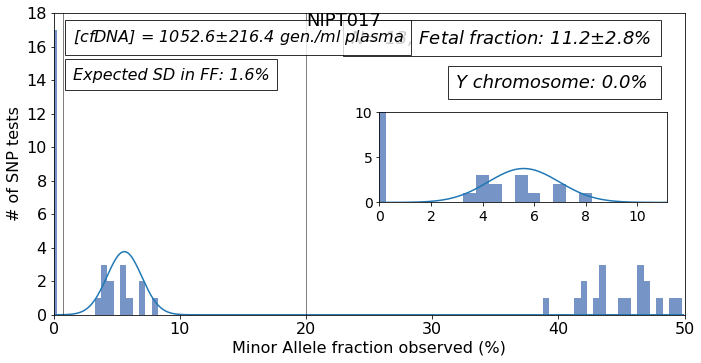

In [27]:
data = pd.read_csv(input_file, sep=',', index_col=False,usecols=cols_snp + cols_quant ,na_values=list_na)

df_snp = CreateMAFDataframe(data, Sample_name, SNP_assays, SNP_min_droplets, cols_snp)

df_quant = CreateQuantDataframe(data, Sample_name, Quant_assays, cols_quant)

#Quantification calculations
C_cfDNA, SD_cfDNA, PoissSD_cfDNA, DNA_input_preamp, Err_input_preamp =  QuantifyDNAInput(df_quant)

#Quantifications from SNP results
ffrac, InputDNA_Fetal_Allele, Err_InputDNA_Fetal_Allele, ErrPoiss_InputDNA_Fetal_Allele,\
Err_fetfrac_1, Err_fetfrac_2, Y_fraction = QuantifySNPresults(df_snp)

#Make plot
Make_SNP_plot2()

#Make output table
output_table = MakeOutputTable(df_quant, df_snp)

output_table.to_csv( output_folder + Sample_name + '_MAF.csv')

#Print log file with main results
log_list = [['v_plasma_ml', v_plasma], 
            ['v_elution_ul', v_elution], 
            ['v_ddpcr_ul', v_ddpcr],
            ['droplet_size_nl', droplet_size*1000.],
            ['v_input_quant_ul', v_input_quant],
            ['v_input_preamp_ul', v_input_preamp],
            ['MAF_min_thres', min_thres], 
            ['MAF_max_thres', max_thres],
            ['Mean_DNA_Quantif_counts', df_quant.total_DNA_input.mean()],
            ['SD_DNA_Quantif_counts', df_quant.total_DNA_input.std()], 
            ['SD_Poisson_counts', df_quant.SD_total_DNA_input.mean()], 
            ['Mean_cfDNA_counts_per_ml_plasma', C_cfDNA],
            ['SD_cfDNA_counts_per_ml_plasma', SD_cfDNA],
            ['SD_Poisson_cfDNA_counts_per_ml_plasma', PoissSD_cfDNA],
            ['Min_range_ffrac', min_thres],
            ['Max_range_ffrac', max_thres],
            ['SNPs_in_ffrac_range', len(ffrac)],
            ['Fetal_fraction_Mean', ffrac.mean()],
            ['Fetal_fraction_Median', ffrac.median()],
            ['Fetal_fraction_SD', ffrac.std()],
            ['Y_chromosome_fraction', Y_fraction],
            ['Expected_SD_from_quant_error', Err_fetfrac_1],
            ['Expected_SD_from_Poisson_MAF', Err_fetfrac_2]]

WriteListToCSV(log_folder + Sample_name + '_log.csv',log_columns,log_list)

#Print main results on screen
print_results(df_quant, df_snp)